In [1]:
# Continue with regular imports

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix  
from collections import Counter
import random
from tqdm import tqdm
from sklearn import svm
from sklearn import metrics

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def get_train_test_loader(data_dir,
                          batch_size,
                          augment,
                          shuffle=True,
                          SUBSET_RATIO = 0.05):

    # define normalizer
    normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010])    # Normalize a tensor image with mean and standard deviation for n channels, this transform will normalize each channel of the input.


    # define transforms
    test_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),          # transforms.ToTensor() automatically scales the images to [0,1] range
                normalize])


    if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
    else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

    # download and create datasets
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=test_transform, download=True)

    # Define the size of the subset
    train_subset_size = int(SUBSET_RATIO * len(train_dataset))
    test_subset_size = int(SUBSET_RATIO * len(test_dataset))

    # Randomly select subset indices
    train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
    test_subset_indices = torch.randperm(len(test_dataset))[:test_subset_size]


    # Create a subset of the original dataset using the selected indices
    train_subset = Subset(train_dataset, train_subset_indices)
    test_subset = Subset(test_dataset, test_subset_indices)


    # define the data loaders
    train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle = shuffle)
    test_loader = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=shuffle)

    return (train_dataset, test_dataset, train_loader, test_loader)

BATCH_SIZE = 64
train_data, test_data, train_dataloader, test_dataloader = get_train_test_loader(data_dir = 'CIFAR10_data',
                                                    batch_size = BATCH_SIZE,
                                                    augment = False)
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Files already downloaded and verified
Files already downloaded and verified
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fc62c8d6940>, <torch.utils.data.dataloader.DataLoader object at 0x7fc62c8d6850>)
Length of train dataloader: 40 batches of 64
Length of test dataloader: 8 batches of 64


In [3]:
def set_AlexNet():
  # Set the manual seeds
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # Load pretrained model
  model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
  model.eval()

  # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
  for param in model.parameters():
    param.requires_grad = False

  features = list(model.classifier.children())[:-1] # Remove last layer
  model.classifier = nn.Sequential(*features) # Replace the model classifier

  return model


In [4]:
# Print a summary using torchinfo (uncomment for actual output)
model = set_AlexNet()
summary(model=model, 
        input_size=(32, 3, 227, 227), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 227, 227]    [32, 4096]           --                   False
├─Sequential (features)                  [32, 3, 227, 227]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 227, 227]    [32, 64, 56, 56]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 56, 56]     [32, 64, 56, 56]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 56, 56]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6) 

In [5]:
def feature_extractor(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
               ):
  """Extract features of CNN model.
  Args:
  model: A PyTorch model to be trained.
  dataloader: A DataLoader instance for the model to be trained on.
  Returns:
  A tuple of extracted features and true labels.
  In the form (extracted_features_, true_labels_).
  """
  # Setup extracted features and true labels list
  extracted_features = []
  true_labels = []

  # Extract features 
  for X, y in tqdm(dataloader):
    features = model(X)
    extracted_features.append(features)
    true_labels.append(y)

  # Reshape features and labels and convert them to numpy array
  extracted_features_ = torch.cat(extracted_features).numpy()
  true_labels_ = torch.cat(true_labels).numpy()

  return extracted_features_,true_labels_

In [15]:
train_extracted_features, train_labels = feature_extractor(model,
                                                          train_dataloader)

C = 1.0
# Train an SVM model
clf = svm.SVC(kernel='poly', degree=2, decision_function_shape='ovr',  C=C)
clf.fit(train_extracted_features, train_labels)
pred_train_labels = clf.predict(train_extracted_features)

100%|██████████| 40/40 [01:32<00:00,  2.31s/it]


In [19]:
test_extracted_features, test_labels = feature_extractor(model,
                                                        test_dataloader)

# Predict on features with SVM
pred_test_labels = clf.predict(test_extracted_features)

100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


In [20]:
# let's see some metrics
print('Train data---------')
print(f'Train Accuracy: {metrics.accuracy_score(train_labels, pred_train_labels)}')
print(f'Train Precision: {metrics.precision_score(train_labels, pred_train_labels, average="micro")}')
print(f'Train Recall: {metrics.recall_score(train_labels, pred_train_labels, average="macro")}')
print(f'Train F1: {metrics.f1_score(train_labels, pred_train_labels, average="micro")}')

print('Test data---------')
print(f'Test Accuracy: {metrics.accuracy_score(test_labels, pred_test_labels)}')
print(f'TestPrecision: {metrics.precision_score(test_labels, pred_test_labels, average="micro")}')
print(f'Test Recall: {metrics.recall_score(test_labels, pred_test_labels, average="macro")}')
print(f'Test F1: {metrics.f1_score(test_labels, pred_test_labels, average="micro")}')

Train data---------
Train Accuracy: 0.9104
Train Precision: 0.9104
Train Recall: 0.9100196682774667
Train F1: 0.9103999999999999
Test data---------
Test Accuracy: 0.746
TestPrecision: 0.746
Test Recall: 0.7433212103521523
Test F1: 0.746


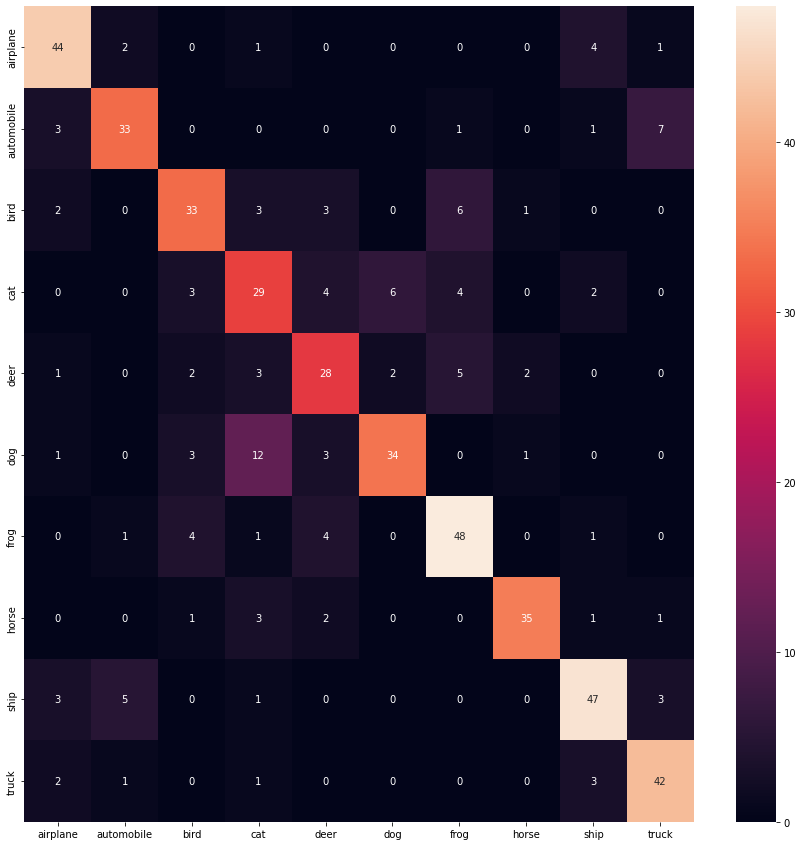

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,15))
cm = confusion_matrix(test_labels, pred_test_labels)
f = sns.heatmap(cm, annot=True,fmt='d',xticklabels=train_data.classes,yticklabels=train_data.classes)
plt.show()